In [5]:
from keras import layers, models
from keras.applications import VGG16
from keras import backend as k
import numpy as np

In [2]:
model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = k.mean(layer_output[:, :, :, filter_index])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
layer_output

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>

In [12]:
grads=k.gradients(loss,model.input)[0]

In [13]:
grads/=(k.sqrt(k.mean(k.square(grads)))+1e-5)

In [14]:
iterate=k.function([model.input],[loss,grads])

In [20]:
loss_value,grads_value=iterate([np.zeros((1,150,150,3))])

In [22]:
grads_value

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)

In [16]:
input_img_data=np.random.random((1,150,150,3))*20+128.
step=1.
for i in range(50):
    loss_value,grads_value=iterate([input_img_data])
    input_img_data+=grads_value*step


In [17]:
def deprecess_image(x):
    x-=x.mean()
    x/=x.std()
    x*=0.1
    
    x+=0.5
    x=np.clip(x,0,1)
    x*=255
    x=np.clip(x,0,255).astype('uint8')
    return x

In [18]:
import matplotlib.pyplot as plt

In [23]:
# plt.imshow(deprecess_image(input_img_data[0]))

In [33]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = k.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = k.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (k.sqrt(k.mean(k.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = k.function([model.input], [loss, grads])

    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprecess_image(img)

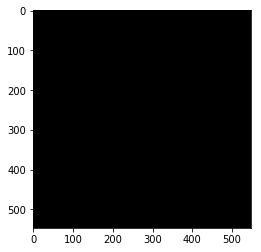

In [35]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5
    
    results=np.zeros((8*size+7*margin,8*size+7*margin,3))
    
    for i in range(8):
        for j in range(8):
            filter_img=generate_pattern(layer_name,i+(j*8),size=size)
            
            horizontal_start=i*size+i*margin
            horizontal_end=horizontal_start+size
            vertical_start=j*size+margin
            vertical_end=vertical_start+size
            results[horizontal_start:horizontal_end,vertical_start:vertical_end]
    
    plt.imshow(results)
    